In [1]:
# ===========================
# Core Python
# ===========================
import os
import re
import shutil
import contextlib

# ===========================
#  Data Handling
# ===========================
import pandas as pd
import numpy as np
import joblib
from tqdm.auto import tqdm
from wordcloud import WordCloud, STOPWORDS

# ===========================
#  Machine Learning
# ===========================
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ===========================
#  Visualization
# ===========================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# ===========================
#  Explainability
# ===========================
import shap

# ===========================
#  Experiment Tracking
# ===========================
import wandb
from wandb.integration.xgboost import WandbCallback
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import shap
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import os


import os
from transformers import TrainingArguments, EarlyStoppingCallback, AutoModelForSequenceClassification, AutoTokenizer

import wandb
from wandb.integration.xgboost import WandbCallback
import xgboost as xgb # Added import for xgboost
from sklearn.metrics import ConfusionMatrixDisplay # Added import for ConfusionMatrixDisplay


import pandas as pd
import numpy as np
import torch
import os
import shutil
import gc # Garbage Collector pour vider la mémoire
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset



In [2]:
#load the data
df=pd.read_csv("/content/drive/MyDrive/NLP course /dev_phase /subtask1/train/eng.csv")


In [3]:
test=pd.read_csv("/content/drive/MyDrive/NLP course /dev_phase /subtask1/dev/eng.csv")


In [4]:
df.head()


,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0


In [5]:
test.head()

,id,text,polarization
0,eng_f66ca14d60851371f9720aaf4ccd9b58,God is with Ukraine and Zelensky,NaN
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,"4 Dems, 2 Republicans Luzerne County Council s...",NaN
2,eng_95770ff547ea5e48b0be00f385986483,Abuse Survivor Recounts Her Struggles at YWCA ...,NaN
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,"After Rwanda, another deportation camp disaster",NaN
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,Another plea in Trump election interference probe,NaN


In [6]:
# Data
X = df["text"].astype(str).values
y = df["polarization"].values


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
# --- STEP 1: Text Cleaning Function ---
def clean_text(text):
    # Safety check: ensure we always work with a string
    text = str(text).lower()

    # 1. Handle English contractions (e.g., "don't" → "do not")
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)

    # 2. Replace exclamation marks with a token (useful for polarity detection)
    text = re.sub(r"[!]", " exclamation_mark ", text)

    return text

# --- FIX: Convert to Pandas Series to allow .apply() ---
X_train_clean = pd.Series(X_train).apply(clean_text)
X_test_clean = pd.Series(X_test).apply(clean_text)


# --- STEP 2: TF-IDF Configuration ---

# Custom stopword list (keep negations because they are essential for sentiment)
my_stop_words = list(ENGLISH_STOP_WORDS)
keep_words = ['not', 'no', 'nor', 'none', 'neither', 'never', 'cannot']

for word in keep_words:
    if word in my_stop_words:
        my_stop_words.remove(word)

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),   # Captures "not good", "do not like", etc.
    stop_words=my_stop_words
)

# --- STEP 3: Transform the Data ---
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)

print("Done! The TF-IDF preprocessing ran successfully.")
print(f"Training matrix shape: {X_train_tfidf.shape}")

# Quick test: check if the model learned the exclamation mark token
features = tfidf.get_feature_names_out()
if "exclamation_mark" in features:
    print("Success: The model learned the 'exclamation_mark' feature!")


Done! The TF-IDF preprocessing ran successfully.
Training matrix shape: (2577, 20000)
Success: The model learned the 'exclamation_mark' feature!


In [9]:
# XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    tree_method="hist"   # very fast
)

# Training
model.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7131782945736435
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       410
           1       0.66      0.43      0.52       235

    accuracy                           0.71       645
   macro avg       0.70      0.65      0.66       645
weighted avg       0.70      0.71      0.70       645



In [10]:
# --- 1. Progress Bar Function ---
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


# --- 2. Model Definition ---

# Note: Make sure y_train contains only 0s and 1s
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method="hist",
    device="cpu"
)

param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9],  # Important for TF-IDF
    'gamma': [0, 0.1, 0.5]
}


# --- 3. RandomizedSearch with scoring='f1' ---

n_iter_search = 20
cv_folds = 3

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    scoring='f1',     # <--- Binary F1 Score (focuses on class 1)
    n_jobs=-1,
    cv=cv_folds,
    verbose=0,
    random_state=42
)


# --- 4. Execution ---
print("Starting hyperparameter tuning (Optimizing Binary F1-Score)...")
total_tasks = n_iter_search * cv_folds

with tqdm_joblib(tqdm(desc="Hyperparameter Tuning", total=total_tasks)):
    random_search.fit(X_train_tfidf, y_train)


# --- 5. Results ---
print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best Validation F1-Score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

print("\n--- Final Test Set Results ---")
# Explicit Binary F1 Score
print(f"F1 Score (Binary): {f1_score(y_test, y_pred):.4f}")
print("-" * 30)
print(classification_report(y_test, y_pred))


Starting hyperparameter tuning (Optimizing Binary F1-Score)...


Hyperparameter Tuning: 100%|██████████| 60/60 [03:32<00:00,  3.54s/it]


Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}
Best Validation F1-Score: 0.5709

--- Final Test Set Results ---
F1 Score (Binary): 0.5163
------------------------------
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       410
           1       0.63      0.44      0.52       235

    accuracy                           0.70       645
   macro avg       0.68      0.64      0.65       645
weighted avg       0.69      0.70      0.69       645



In [11]:
# Step 1 — Split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    stratify=y,       # Important to preserve class balance
    test_size=0.3,    # 30% will be used for (Validation + Test)
    random_state=42
)

# Step 2 — Split Temp into Validation (15%) and Test (15%)
# Since X_temp = 30%, we split it into two equal parts (0.5)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    stratify=y_temp,   # Keep class balance in the subsets
    test_size=0.5,     # 50% of 30% = 15% of the full dataset
    random_state=42
)

# Shapes check
print(f"Train shape : {X_train.shape} ({len(X_train)/len(X):.0%})")
print(f"Val shape   : {X_val.shape}   ({len(X_val)/len(X):.0%})")
print(f"Test shape  : {X_test.shape}  ({len(X_test)/len(X):.0%})")


Train shape : (2255,) (70%)
Val shape   : (483,)   (15%)
Test shape  : (484,)  (15%)


In [12]:
# 1. Cleaning (apply the previously defined clean_text function)
X_train_clean = pd.Series(X_train).apply(clean_text)
X_val_clean   = pd.Series(X_val).apply(clean_text)    # <-- New
X_test_clean  = pd.Series(X_test).apply(clean_text)

# 2. TF-IDF Configuration (your previous settings)
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words=my_stop_words
)

# 3. Fit & Transform
# LEARN the vocabulary ONLY on the training data
X_train_tfidf = tfidf.fit_transform(X_train_clean)

# APPLY the same vocabulary to validation and test sets
X_val_tfidf   = tfidf.transform(X_val_clean)
X_test_tfidf  = tfidf.transform(X_test_clean)


In [13]:
# --- 1. TQDM Callback Class ---
class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total_rounds):
        self.total_rounds = total_rounds
        self.pbar = None

    def before_training(self, model):
        self.pbar = tqdm(total=self.total_rounds, desc="XGBoost Training")
        return model

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)

        # Display validation score if available
        try:
            results = list(evals_log.values())[0]
            metric_name = list(results.keys())[0]
            current_score = results[metric_name][-1]
            self.pbar.set_postfix({f"Val {metric_name}": f"{current_score:.4f}"})
        except:
            pass

        return False

    def after_training(self, model):
        self.pbar.close()
        return model


# --- 2. Model Configuration & Training ---
n_estimators = 1000

# Add callback directly inside the constructor
model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=0.05,
    max_depth=6,
    colsample_bytree=0.8,
    tree_method="hist",
    eval_metric="logloss",
    early_stopping_rounds=50,
    callbacks=[TqdmCallback(total_rounds=n_estimators)],   # <-- Moved here
    device="cpu"
)

print("Starting training...")

# No 'callbacks' argument inside fit()
model.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_val_tfidf, y_val)],
    verbose=False
)

# --- 3. Evaluation ---
print(f"\nBest iteration: {model.best_iteration}")
y_pred = model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Starting training...


XGBoost Training:  28%|██▊       | 277/1000 [00:49<02:08,  5.63it/s, Val logloss=0.5829]


Best iteration: 226
Test Accuracy: 0.6797520661157025


In [14]:
# Include both TRAIN and VALIDATION in eval_set so we can compare curves
eval_set = [(X_train_tfidf, y_train), (X_val_tfidf, y_val)]

model.fit(
    X_train_tfidf, y_train,
    eval_set=eval_set,
    verbose=False
    # Note: Your tqdm callbacks remain active because they were defined in the constructor
)

# Retrieve training logs
results = model.evals_result()


XGBoost Training:  28%|██▊       | 277/1000 [00:48<02:06,  5.73it/s, Val logloss=0.4145]


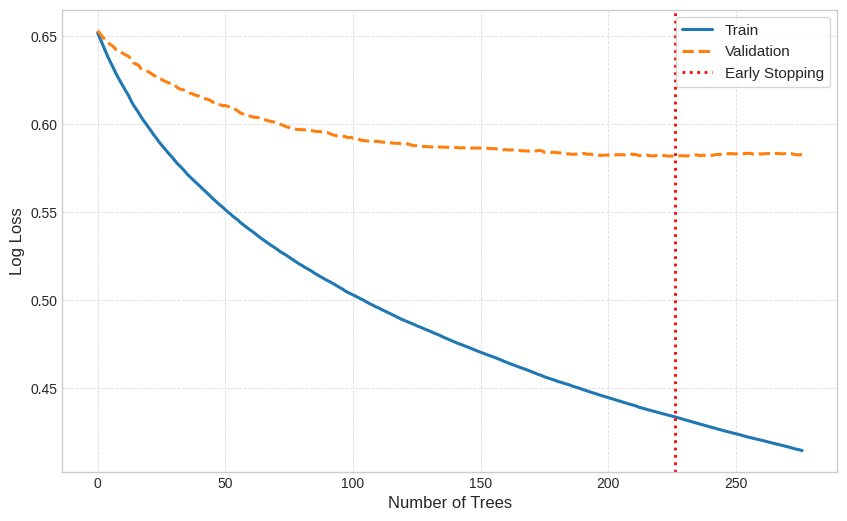

In [15]:
# Retrieve the evaluation results (if not already done)
results = model.evals_result()

epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Professional Matplotlib Style
plt.style.use("seaborn-v0_8-whitegrid")   # propre, pro, lisible

fig, ax = plt.subplots(figsize=(10, 6))

# Training curve
ax.plot(
    x_axis,
    results['validation_0']['logloss'],
    label='Train',
    linewidth=2.2
)

# Validation curve
ax.plot(
    x_axis,
    results['validation_1']['logloss'],
    label='Validation',
    linestyle='--',
    linewidth=2.2
)

# Grid
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

# Axis labels
ax.set_ylabel('Log Loss', fontsize=12)
ax.set_xlabel('Number of Trees', fontsize=12)

# Early stopping marker
if hasattr(model, 'best_iteration') and model.best_iteration < epochs - 1:
    ax.axvline(
        x=model.best_iteration,
        linestyle=':',
        color='red',
        linewidth=2,
        label='Early Stopping'
    )

# Legend, professional style
ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=False)

# Save as PDF (professional quality)
plt.savefig("learning_curve.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()


**Interpretation**;

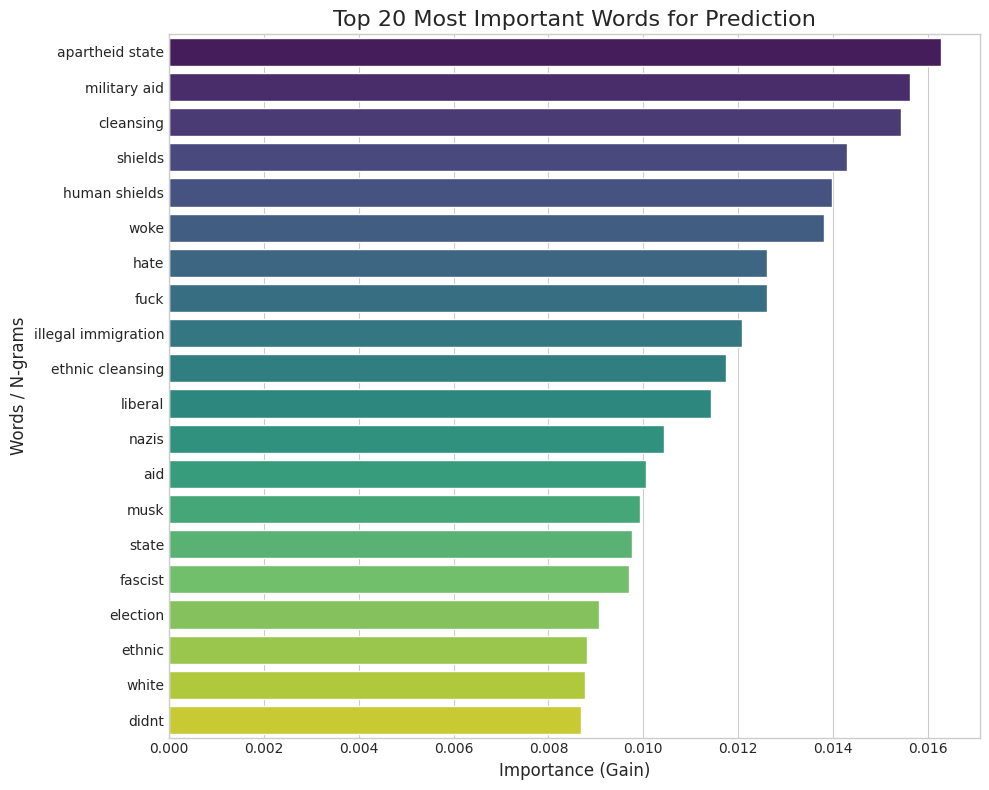

In [16]:

# 1. Get feature importance
importance = model.feature_importances_

# 2. Get feature names
feature_names = tfidf.get_feature_names_out()

# 3. Create DataFrame
df_importance = pd.DataFrame({
    'word': feature_names,
    'importance': importance
})

# 4. Sort and take Top 20
top_20 = df_importance.sort_values(by='importance', ascending=False).head(20)

# 5. Plotting with Seaborn
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

ax = sns.barplot(
    x='importance',
    y='word',
    hue='word',       # Required for Seaborn >=0.14
    data=top_20,
    palette='viridis',
    dodge=False
)

# Remove legend safely
leg = ax.get_legend()
if leg:
    leg.remove()

# Titles and labels
plt.title('Top 20 Most Important Words for Prediction', fontsize=16)
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Words / N-grams', fontsize=12)
plt.tight_layout()

# 6. Save as PDF
plt.savefig('top_20_feature_importance.pdf', format='pdf')
plt.show()


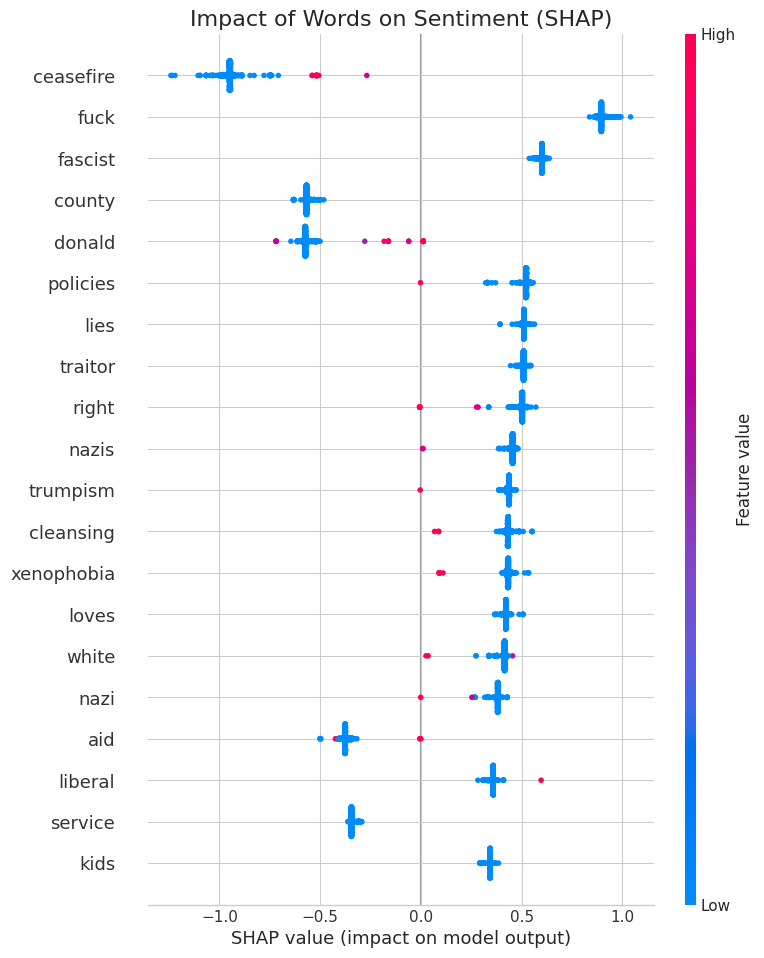

In [17]:
# 1. Explainer
explainer = shap.TreeExplainer(model)

# 2. Subset
X_subset = X_test_tfidf[:1000]

# 3. Convert to dense if sparse (important for SHAP coloring)
if hasattr(X_subset, "toarray"):
    X_subset_dense = X_subset.toarray()
else:
    X_subset_dense = X_subset

# 4. Calculate SHAP values
shap_values = explainer.shap_values(X_subset_dense)

# 5. Feature names
feature_names = tfidf.get_feature_names_out()

# 6. Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_subset_dense,
    feature_names=feature_names,
    show=False,   # Allows PDF saving
    plot_type="dot"  # Default beeswarm
)

plt.title("Impact of Words on Sentiment (SHAP)", fontsize=16)

# 7. Save as PDF
plt.savefig('shap_summary_plot_colored.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [18]:


# --- 1. Tqdm Callback Class (Unchanged) ---
class TqdmCallback(xgb.callback.TrainingCallback):
    def __init__(self, total_rounds):
        self.total_rounds = total_rounds
        self.pbar = None

    def before_training(self, model):
        self.pbar = tqdm(total=self.total_rounds, desc="XGBoost Training")
        return model

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        # Display validation logloss in the progress bar
        try:
            # We look for validation_1 because validation_0 will be the Train set now
            results = evals_log['validation_1']['logloss']
            current_score = results[-1]
            self.pbar.set_postfix({"Val LogLoss": f"{current_score:.4f}"})
        except:
            pass
        return False

    def after_training(self, model):
        self.pbar.close()
        return model

# --- 2. Configuration & Training ---
n_estimators = 1000

# UPDATE: Adding Regularization parameters
model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=0.05,

    # --- Regularization Changes to fix Overfitting ---
    max_depth=4,            # Reduced from 6 to 4 (Simpler model)
    subsample=0.7,          # Use only 70% of rows per tree
    colsample_bytree=0.5,   # Reduced from 0.8 to 0.5 (Force model to use different words)
    min_child_weight=3,     # Increased to prevent isolating outliers
    gamma=1.0,              # Minimum loss reduction required to split
    # -------------------------------------------------

    tree_method="hist",
    eval_metric="logloss",
    early_stopping_rounds=50,
    callbacks=[TqdmCallback(total_rounds=n_estimators)],
    device="cpu"
)

print("Starting training with regularization...")

# UPDATE: We include BOTH Train and Val to check the curves later
model.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_train_tfidf, y_train), (X_val_tfidf, y_val)],
    verbose=False
)

# --- 3. Evaluation ---
print(f"\nBest Iteration: {model.best_iteration}")

y_pred = model.predict(X_test_tfidf)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Starting training with regularization...


XGBoost Training:  32%|███▏      | 322/1000 [00:55<01:57,  5.79it/s, Val LogLoss=0.5848]


Best Iteration: 271
Test Accuracy: 0.6942


In [19]:
test['text_clean'] = test['text'].astype(str).apply(clean_text)

X_submission_tfidf = tfidf.transform(test['text_clean'])

test['polarization'] = model.predict(X_submission_tfidf)

print(test[['id', 'text', 'polarization']].head(10))

# test[['id', 'polarization']].to_csv("submission.csv", index=False)

                                     id  \
0  eng_f66ca14d60851371f9720aaf4ccd9b58   
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb   
2  eng_95770ff547ea5e48b0be00f385986483   
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf   
4  eng_07781aa88e61e7c0a996abd1e5ea3a20   
5  eng_153d96f9dc27f0602c927223404d94b5   
6  eng_4ab5a4cc5c87d0af9cf4b80c301647bf   
7  eng_e75a95ba52930d6d72d503ab9469eb29   
8  eng_eb8fab668668f9959cafdecbfc0f081a   
9  eng_702724dc168d600e788d775c8e651f36   

                                                text  polarization  
0                   God is with Ukraine and Zelensky             0  
1  4 Dems, 2 Republicans Luzerne County Council s...             0  
2  Abuse Survivor Recounts Her Struggles at YWCA ...             0  
3    After Rwanda, another deportation camp disaster             0  
4  Another plea in Trump election interference probe             1  
5              any number of southern red states tbh             0  
6     Breitbart is the new age grocery aisl

In [20]:
probs = model.predict_proba(X_submission_tfidf)[:, 1]

test['probability'] = probs

print("--- Top 3 texts most SURELY Polarized ---")
top_polarized = test.sort_values(by='probability', ascending=False).head(3)
print(top_polarized[['text', 'probability']])

print("\n--- Top 3 texts most SURELY Neutral ---")
top_neutral = test.sort_values(by='probability', ascending=True).head(3)
print(top_neutral[['text', 'probability']])

print("\n--- Ambiguous Texts (Model is hesitating) ---")
ambiguous = test[(test['probability'] > 0.45) & (test['probability'] < 0.55)].head(3)
print(ambiguous[['text', 'probability']])

--- Top 3 texts most SURELY Polarized ---
                                                  text  probability
96   I have a weird point to mention but I always f...     0.958007
107  Say it LOUDER! Not enough fuckwits are naming ...     0.837069
99   Long live Mother Russia. Listen to my advice s...     0.795215

--- Top 3 texts most SURELY Neutral ---
                                                 text  probability
21     House GOP accuses President Biden of influence     0.060149
16  Guilford County GOP Congratulates New School B...     0.085854
17  Hamas has nobody else to rescue them. Its over...     0.086631

--- Ambiguous Texts (Model is hesitating) ---
                                                 text  probability
3     After Rwanda, another deportation camp disaster     0.465984
39  Not all the Nazis were from Germany, either Th...     0.499881
50  Springfields Haitian community reacts to Trump...     0.492480


In [21]:
top_neutral[['text', 'probability']]


,text,probability
21,House GOP accuses President Biden of influence,0.060149
16,Guilford County GOP Congratulates New School B...,0.085854
17,Hamas has nobody else to rescue them. Its over...,0.086631


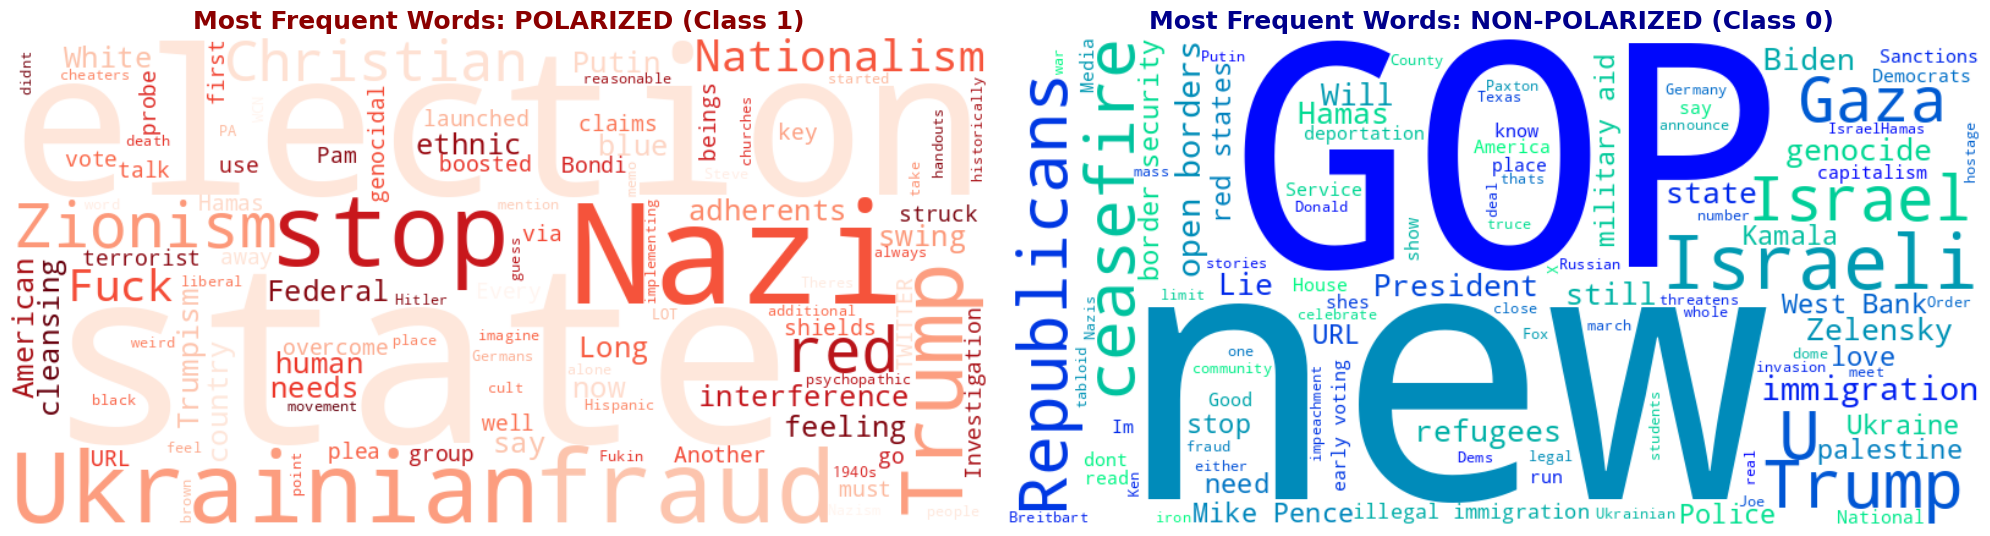

In [22]:

# 1. Separate text by class (Polarized vs Non-Polarized)
# We convert to string to handle potential missing values safely
polarized_text_series = test[test['polarization'] == 1]['text'].astype(str)
non_polarized_text_series = test[test['polarization'] == 0]['text'].astype(str)

# Join all tweets/texts into two massive strings
text_polarized = " ".join(polarized_text_series)
text_non_polarized = " ".join(non_polarized_text_series)

# 2. Configure Stopwords
# We load standard English stopwords and add specific social media noise
stopwords = set(STOPWORDS)
# Adding common Twitter/Web artifacts to ignore
stopwords.update(["https", "http", "t", "co", "amp", "s"])

# 3. Create WordCloud Objects

# --- Class 1: POLARIZED (Red Theme) ---
wc_polarized = WordCloud(
    background_color='white',
    max_words=100,              # Display top 100 words
    stopwords=stopwords,
    colormap='Reds',            # Red palette for polarization/intensity
    width=800, height=400,
    random_state=42
).generate(text_polarized)

# --- Class 0: NON-POLARIZED (Blue Theme) ---
wc_non_polarized = WordCloud(
    background_color='white',
    max_words=100,
    stopwords=stopwords,
    colormap='winter',          # Blue/Cool palette for neutral content
    width=800, height=400,
    random_state=42
).generate(text_non_polarized)

# 4. Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot Class 1 (Left side)
ax[0].imshow(wc_polarized, interpolation='bilinear')
ax[0].set_title("Most Frequent Words: POLARIZED (Class 1)", fontsize=18, color='darkred', weight='bold')
ax[0].axis('off') # Hide axes for cleaner look

# Plot Class 0 (Right side)
ax[1].imshow(wc_non_polarized, interpolation='bilinear')
ax[1].set_title("Most Frequent Words: NON-POLARIZED (Class 0)", fontsize=18, color='darkblue', weight='bold')
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [23]:
output_folder = 'subtask_1'
zip_filename = 'submission_subtask_1'

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder)

test['polarization'] = test['polarization'].astype(int)

test['lang_code'] = test['id'].str.split('_').str[0]

print(f"Generating files in the folder '{output_folder}'...")

unique_langs = test['lang_code'].unique()

for lang in unique_langs:
    subset = test[test['lang_code'] == lang]

    filename = f"pred_{lang}.csv"
    filepath = os.path.join(output_folder, filename)

    subset[['id', 'polarization']].to_csv(filepath, index=False)

    print(f"File created: {filename} ({len(subset)} rows)")

print("\nCompressing the folder...")
shutil.make_archive(zip_filename, 'zip', root_dir='.', base_dir=output_folder)

print(f"\nREADY! The file to upload is: {zip_filename}.zip")

Generating files in the folder 'subtask_1'...
File created: pred_eng.csv (160 rows)

Compressing the folder...

READY! The file to upload is: submission_subtask_1.zip


In [24]:
MODEL_CHECKPOINT = "distilbert-base-uncased"
BATCH_SIZE = 16
MAX_LENGTH = 128
LEARNING_RATE = 2e-5
EPOCHS = 4

def load_and_prepare_data(file_path, task_type="binary"):
    df = pd.read_csv(file_path)
    df['text'] = df['text'].fillna("")

    if task_type == "binary":
        df['labels'] = df['polarization'].astype(int)
        label_list = ['Non-Polarized', 'Polarized']
        num_labels = 2
        problem_type = "single_label_classification"

    else:
        label_cols = [c for c in df.columns if c not in ['id', 'text', 'polarization']]
        df['labels'] = df[label_cols].values.tolist()
        df['labels'] = df['labels'].apply(lambda x: [float(i) for i in x])

        label_list = label_cols
        num_labels = len(label_cols)
        problem_type = "multi_label_classification"

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    return train_dataset, val_dataset, num_labels, problem_type, label_list

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if len(labels.shape) > 1 and labels.shape[1] > 1:
        probs = 1 / (1 + np.exp(-predictions))
        y_pred = (probs > 0.5).astype(int)
        y_true = labels

    else:
        y_pred = np.argmax(predictions, axis=1)
        y_true = labels

    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred) if len(labels.shape) == 1 else 0

    return {"f1_macro": f1, "accuracy": acc}

def run_fine_tuning(file_path, task_name, output_dir):
    print(f"\n{'='*40}")
    print(f"STARTING FINE-TUNING FOR: {task_name}")
    print(f"{'='*40}")

    if "subtask1" in file_path:
        task_type = "binary"
    else:
        task_type = "multi_label"

    train_ds, val_ds, num_labels, problem_type, label_list = load_and_prepare_data(file_path, task_type)
    print(f"Task Type: {task_type}")
    print(f"Labels ({num_labels}): {label_list}")
    print(f"Training samples: {len(train_ds)} | Validation samples: {len(val_ds)}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

    def tokenize_func(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

    tokenized_train = train_ds.map(tokenize_func, batched=True)
    tokenized_val = val_ds.map(tokenize_func, batched=True)

    cols_to_remove = [c for c in tokenized_train.column_names if c not in ['input_ids', 'attention_mask', 'labels']]
    tokenized_train = tokenized_train.remove_columns(cols_to_remove)
    tokenized_val = tokenized_val.remove_columns(cols_to_remove)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CHECKPOINT,
        num_labels=num_labels,
        problem_type=problem_type
    )

    training_args = TrainingArguments(
        output_dir=f"{output_dir}/{task_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=True,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    final_path = f"{output_dir}/{task_name}_final"
    trainer.save_model(final_path)
    print(f"Model saved to: {final_path}")

In [25]:
# --- RUN TRAINING FOR ENGLISH SUBTASK 1 (Polarization Detection) ---
# This creates a binary classifier (0 or 1)
run_fine_tuning("/content/drive/MyDrive/NLP course /dev_phase /subtask1/train/eng.csv", "english_task1_polarization", "./models")


STARTING FINE-TUNING FOR: english_task1_polarization
Task Type: binary
Labels (2): ['Non-Polarized', 'Polarized']
Training samples: 2577 | Validation samples: 645


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4279437545.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,No log,0.444156,0.740197,0.772093
2,No log,0.453499,0.758141,0.781395
3,No log,0.539604,0.747042,0.782946
4,0.384800,0.564774,0.761069,0.792248


Model saved to: ./models/english_task1_polarization_final


In [26]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

MODEL_CHECKPOINT = "microsoft/deberta-v3-base"
BATCH_SIZE = 8
MAX_LENGTH = 128
LEARNING_RATE = 1e-5
EPOCHS = 6

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['text'] = df['text'].fillna("")

    df['labels'] = df['polarization'].astype(int)

    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(df['labels']),
        y=df['labels']
    )
    weights_tensor = torch.tensor(class_weights, dtype=torch.float)

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df), weights_tensor

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    y_pred = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, y_pred, average="macro")
    acc = accuracy_score(labels, y_pred)
    return {"f1_macro": f1, "accuracy": acc}

def train_high_performance(file_path, output_dir):
    print(f"Training SOTA Model: {MODEL_CHECKPOINT} on {file_path}")

    train_ds, val_ds, weights = load_data(file_path)
    print(f"Class Weights calculated: {weights}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

    def tokenize(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

    train_ds = train_ds.map(tokenize, batched=True)
    val_ds = val_ds.map(tokenize, batched=True)

    cols_to_remove = [c for c in train_ds.column_names if c not in ['input_ids', 'attention_mask', 'labels']]
    train_ds = train_ds.remove_columns(cols_to_remove)
    val_ds = val_ds.remove_columns(cols_to_remove)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

    args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=True,
        save_total_limit=1,
        warmup_ratio=0.1,
        logging_dir='./logs',
    )

    trainer = WeightedTrainer(
        class_weights=weights,
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    save_path = f"{output_dir}/deberta_v3_optimized"
    trainer.save_model(save_path)
    print(f"Best Model Saved to: {save_path}")

train_high_performance("/content/drive/MyDrive/NLP course /dev_phase /subtask1/train/eng.csv", "./sota_models")

Training SOTA Model: microsoft/deberta-v3-base on /content/drive/MyDrive/NLP course /dev_phase /subtask1/train/eng.csv
Class Weights calculated: tensor([0.7870, 1.3711])


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2650887543.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B ac

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,No log,0.439902,0.795976,0.804651
2,0.531600,0.464633,0.796958,0.801550
3,0.531600,0.765724,0.803082,0.815504
4,0.321200,0.937838,0.803726,0.815504
5,0.180500,1.057822,0.804012,0.818605
6,0.180500,1.102008,0.812558,0.826357


Best Model Saved to: ./sota_models/deberta_v3_optimized


In [27]:
def train_high_performance(file_path, output_dir):
    print(f"Training SOTA Model: {MODEL_CHECKPOINT} on {file_path}")

    NEW_MAX_LENGTH = 256

    train_ds, val_ds, weights = load_data(file_path)
    print(f"Class Weights calculated: {weights}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

    def tokenize(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=NEW_MAX_LENGTH)

    train_ds = train_ds.map(tokenize, batched=True)
    val_ds = val_ds.map(tokenize, batched=True)

    cols_to_remove = [c for c in train_ds.column_names if c not in ['input_ids', 'attention_mask', 'labels']]
    train_ds = train_ds.remove_columns(cols_to_remove)
    val_ds = val_ds.remove_columns(cols_to_remove)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

    print("Freezing lower layers to prevent overfitting...")

    for param in model.deberta.embeddings.parameters():
        param.requires_grad = False

    for layer in model.deberta.encoder.layer[:6]:
        for param in layer.parameters():
            param.requires_grad = False

    args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        per_device_eval_batch_size=8,
        num_train_epochs=8,
        weight_decay=0.1,
        label_smoothing_factor=0.1,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=True,
        save_total_limit=1,
        warmup_ratio=0.1,
        logging_dir='./logs',
        report_to="none"
    )

    trainer = WeightedTrainer(
        class_weights=weights,
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    save_path = f"{output_dir}/deberta_v3_frozen_optimized"
    trainer.save_model(save_path)
    print(f"Best Model Saved to: {save_path}")

train_high_performance("/content/drive/MyDrive/NLP course /dev_phase /subtask1/train/eng.csv", "./sota_models_v2")

Training SOTA Model: microsoft/deberta-v3-base on /content/drive/MyDrive/NLP course /dev_phase /subtask1/train/eng.csv
Class Weights calculated: tensor([0.7870, 1.3711])


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2650887543.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Freezing lower layers to prevent overfitting...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,No log,0.460139,0.783761,0.801550
2,No log,0.412971,0.797460,0.806202
3,No log,0.479243,0.772608,0.778295
4,0.470900,0.489256,0.789388,0.801550
5,0.470900,0.532257,0.792772,0.803101


Best Model Saved to: ./sota_models_v2/deberta_v3_frozen_optimized


In [30]:
MODEL_CHECKPOINT = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
BATCH_SIZE = 8

def train_single_seed(file_path, seed):
    print(f"\n{'='*40}")
    print(f"STARTING TRAINING WITH SEED: {seed}")
    print(f"{'='*40}")

    output_dir = f"./ensemble_models/seed_{seed}"

    train_ds, val_ds, weights = load_data(file_path)

    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
    def tokenize(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

    train_ds = train_ds.map(tokenize, batched=True)
    val_ds = val_ds.map(tokenize, batched=True)

    cols_to_remove = [c for c in train_ds.column_names if c not in ['input_ids', 'attention_mask', 'labels']]
    train_ds = train_ds.remove_columns(cols_to_remove)
    val_ds = val_ds.remove_columns(cols_to_remove)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

    print("Freezing lower layers...")
    for param in model.deberta.embeddings.parameters():
        param.requires_grad = False
    for layer in model.deberta.encoder.layer[:6]:
        for param in layer.parameters():
            param.requires_grad = False

    args = TrainingArguments(
        output_dir=output_dir,
        seed=seed,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=BATCH_SIZE,
        gradient_accumulation_steps=2,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=8,
        weight_decay=0.1,
        label_smoothing_factor=0.1,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        fp16=True,
        save_total_limit=1,
        warmup_ratio=0.1,
        logging_dir=f'./logs/seed_{seed}',
        report_to="none"
    )

    trainer = WeightedTrainer(
        class_weights=weights,
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    final_path = f"./final_ensemble_models/model_seed_{seed}"
    trainer.save_model(final_path)
    print(f"Model seed {seed} saved to: {final_path}")
    return final_path, val_ds

seeds = [42, 123, 2024]
saved_model_paths = []
validation_dataset = None

for s in seeds:
    path, val_ds = train_single_seed("/content/drive/MyDrive/NLP course /dev_phase /subtask1/train/eng.csv", s)
    saved_model_paths.append(path)
    validation_dataset = val_ds

print("\nALL MODELS TRAINED!")
print("Model paths:", saved_model_paths)


STARTING TRAINING WITH SEED: 42


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2650887543.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Freezing lower layers...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,No log,0.459221,0.787088,0.798450
2,No log,0.412045,0.801984,0.809302
3,No log,0.470930,0.772985,0.776744
4,0.478400,0.483976,0.788299,0.796899
5,0.478400,0.514316,0.798399,0.809302


Model seed 42 saved to: ./final_ensemble_models/model_seed_42

STARTING TRAINING WITH SEED: 123


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2650887543.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Freezing lower layers...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,No log,0.480341,0.793366,0.803101
2,No log,0.454999,0.765911,0.768992
3,No log,0.433243,0.806146,0.817054
4,0.480400,0.497871,0.799871,0.817054
5,0.480400,0.507047,0.800585,0.813953
6,0.480400,0.579702,0.799772,0.812403


Model seed 123 saved to: ./final_ensemble_models/model_seed_123

STARTING TRAINING WITH SEED: 2024


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2577 [00:00<?, ? examples/s]

Map:   0%|          | 0/645 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2650887543.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Freezing lower layers...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
1,No log,0.501399,0.737896,0.739535
2,No log,0.419353,0.810228,0.823256
3,No log,0.428110,0.816320,0.827907
4,0.473000,0.476163,0.811511,0.821705
5,0.473000,0.541197,0.818709,0.831008
6,0.473000,0.599324,0.809133,0.820155
7,0.250600,0.654818,0.807938,0.818605
8,0.250600,0.684548,0.807233,0.820155


Model seed 2024 saved to: ./final_ensemble_models/model_seed_2024

ALL MODELS TRAINED!
Model paths: ['./final_ensemble_models/model_seed_42', './final_ensemble_models/model_seed_123', './final_ensemble_models/model_seed_2024']


In [31]:
TEST_FILE_PATH = "/content/drive/MyDrive/NLP course /dev_phase /subtask1/dev/eng.csv"

BASE_MODEL_CHECKPOINT = "microsoft/deberta-v3-base"

MODEL_PATHS = [
    "./final_ensemble_models/model_seed_42",
    "./final_ensemble_models/model_seed_123",
    "./final_ensemble_models/model_seed_2024"
]

MAX_LENGTH = 256
BATCH_SIZE = 16

print(f"Loading test file: {TEST_FILE_PATH}")
test_df = pd.read_csv(TEST_FILE_PATH)

test_df['text'] = test_df['text'].fillna("")

test_ds = Dataset.from_pandas(test_df)

print(f"Loading Tokenizer from: {BASE_MODEL_CHECKPOINT}")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_CHECKPOINT)

def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

print("Tokenizing...")
test_ds = test_ds.map(tokenize, batched=True)

cols_to_keep = ['input_ids', 'attention_mask']
test_ds = test_ds.remove_columns([c for c in test_ds.column_names if c not in cols_to_keep])

print(f"\nSTARTING ENSEMBLE PREDICTION ({len(MODEL_PATHS)} models)")

all_model_probs = []

for i, model_path in enumerate(MODEL_PATHS):
    print(f"\n[Model {i+1}/{len(MODEL_PATHS)}] Loading from: {model_path}")

    try:
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

        trainer = Trainer(model=model)

        print(f"   -> Calculating predictions...")
        preds_output = trainer.predict(test_ds)

        probs = torch.nn.functional.softmax(torch.tensor(preds_output.predictions), dim=-1).numpy()

        all_model_probs.append(probs)

    except Exception as e:
        print(f"Error with model {model_path}: {e}")
        continue

    del model
    del trainer
    torch.cuda.empty_cache()
    gc.collect()

print("\nCalculating probability average (Ensemble)...")

if not all_model_probs:
    print("No predictions could be made. Check model paths.")
else:
    stacked_probs = np.array(all_model_probs)

    mean_probs = np.mean(stacked_probs, axis=0)

    final_predictions = np.argmax(mean_probs, axis=1)

    print(f"Predictions finished for {len(final_predictions)} rows.")

    submission_df = test_df.copy()
    submission_df['polarization'] = final_predictions

    output_folder = 'subtask_1_ensemble_submission'
    zip_filename = 'submission_subtask_1_ensemble'

    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

    print(f"\nGenerating submission files in '{output_folder}'...")

    submission_df['id'] = submission_df['id'].astype(str)
    submission_df['lang_code'] = submission_df['id'].str.split('_').str[0]

    unique_langs = submission_df['lang_code'].unique()

    for lang in unique_langs:
        subset = submission_df[submission_df['lang_code'] == lang]
        filename = f"pred_{lang}.csv"
        filepath = os.path.join(output_folder, filename)

        subset[['id', 'polarization']].to_csv(filepath, index=False)
        print(f"   -> File created: {filename} ({len(subset)} rows)")

    print(f"\nCompressing to ZIP...")
    shutil.make_archive(zip_filename, 'zip', root_dir='.', base_dir=output_folder)

    print(f"\nSUCCESS! Download the file: {zip_filename}.zip")

Loading test file: /content/drive/MyDrive/NLP course /dev_phase /subtask1/dev/eng.csv
Loading Tokenizer from: microsoft/deberta-v3-base


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing...


Map:   0%|          | 0/160 [00:00<?, ? examples/s]


STARTING ENSEMBLE PREDICTION (3 models)

[Model 1/3] Loading from: ./final_ensemble_models/model_seed_42
   -> Calculating predictions...



[Model 2/3] Loading from: ./final_ensemble_models/model_seed_123
   -> Calculating predictions...



[Model 3/3] Loading from: ./final_ensemble_models/model_seed_2024
   -> Calculating predictions...



Calculating probability average (Ensemble)...
Predictions finished for 160 rows.

Generating submission files in 'subtask_1_ensemble_submission'...
   -> File created: pred_eng.csv (160 rows)

Compressing to ZIP...

SUCCESS! Download the file: submission_subtask_1_ensemble.zip
